This notebook is a prototype in showing how we applied Tukey g-and-h model to the gridded daily model

## Load modules 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import solve

from importlib import reload 
import pybobyqa

from scipy.stats import kurtosis, skew, norm

import cmcrameri as cmc
import cartopy
mollweide = cartopy.crs.Mollweide(central_longitude=0)
geodetic = cartopy.crs.Geodetic()

import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Load data

The gridded daily data is too large. We read the data in different portions and distribute the jobs in clusters

In [2]:
#---
# Code for reading gridded daily data
# Assume we get the gridded daily temperature data: temp, with dimension T * M * N * runsUsed
#     T: number of days (34675)
#     M: number of latitudes (192)
#     N: number of longitudes (288)
#     runsUsed: runsUsed (6)
#---

data = np.load('../Model4-gridded-monthly-axial-symmetric//monthly_mean.npz')
lon = data['lon']
lat = data['lat']

data = np.load('../forcing.npz')
forcing = data['forcing']

year = forcing[:,0].astype('int')
forcing = forcing[:,1]

selectYears = range(2020, 2101, 20)
selectDays = np.array([np.arange( (x-2006)*365, (x-2005)*365 ) for x in selectYears])
selectDays = selectDays.flatten()

nDays = selectDays.size

### Inference functions

In [3]:
def getK(phi):
    K = np.zeros((365,365))
    K[0,0] = 1
    for col in range(1,365):
        K[0,col] = phi * K[0,col-1]
    for row in range(1,365):
        K[row,row:] = K[row-1, row-1:-1]
    K = K + K.T
    K[range(365),range(365)] = 1

    return K

def getX(rho):
    X = np.ones((T,3 + 2*nHarmonics))
    
    # Calculate the past trajectory of forcing for year 2006
    _coef = 1
    _traj = 0;
    for year in range(239,-1,-1): # forcing[239] is the forcing for 2004
        _traj += _coef * forcing[year]
        _coef *= rho
    _traj *= (1-rho)
    
    for day in range(T):
        year = day//365
        _year = year+241 # 241 is the index for year 2006 in forcing
        
        X[day,1] = forcing[_year] 
        
        if day%365 == 0: # Jan 1
            _traj = (1-rho) * forcing[_year-1] + rho * _traj

        X[day,2] = _traj
        
    for harmonic in range(nHarmonics):
        X[:, harmonic+3]            = np.cos( 2*np.pi * np.arange(0,T) / 365 * (harmonic+1) )
        X[:, harmonic+3+nHarmonics] = np.sin( 2*np.pi * np.arange(0,T) / 365 * (harmonic+1) )
        
    return X

def tgh_trans(z, g, h):
    if np.abs(g) < 1e-14:
        value = z * np.exp(h*z*z/2)
    else:
        value = (np.exp(g*z) - 1) * np.exp(h*z*z/2) / g
        
    return value

obj = lambda z: (tghPar - tgh_trans(z, gPar, hPar))**2

def tgh_inverse(tgh, g, h):
    global tghPar, gPar, hPar
    tghPar, gPar, hPar = tgh, g, h
    
    tghList = tgh_trans(zList, gPar, hPar)

    if tghPar > tghList[-1] or tghPar <tghList[0]:
        normal = pybobyqa.solve(obj, x0 = [0], bounds = ([-1000], [1000])).x[0]
    else:
        index = np.where(tghPar < tghList)[0][0]
        normal = zList[index]
    
    return normal

def tgh_pdf(x, g, h, scale, sigma, phi):
    z = tgh_inverse(x/scale, g, h)

    factor1 = scale * np.exp(h*z*z/2)
    factor2 = np.exp(g*z) + (np.exp(g*z)-1) * h * z / g
    
    factor = factor1 * factor2
    pdf = norm.pdf( z, loc = 0, scale = sigma / np.sqrt(1-phi*phi) ) / factor
    
    return pdf

def neg_llh_step1(arg):    
    global tghPar, gPar, hPar

    beta = arg[:9]
    rho, phi, sigma, scale, gPar, hPar = arg[9:]
        
    # Build X
    X = getX(rho)
    
    X = X[selectDays]

    # Get residual
    tgh = (data.T - X @ beta) / scale # dim: runsUsed, nDays

    # TGH inverse and get epsilon
    tgh = tgh.flatten()

    tghList = tgh_trans(zList, gPar, hPar)

    refit = []
    index = np.zeros_like(tgh, dtype = 'int')
    for i, x in enumerate(tgh):
        if x > tghList[-1] or x <tghList[0]:
            refit.append(i)
        else:
            index[i] = np.where(x<tghList)[0][0]
    epsilon = zList[index]
    
    for i in refit:
        tghPar = tgh[i]
        epsilon[i] = pybobyqa.solve(obj, x0 = [0], bounds = ([-1000], [1000])).x[0]

    epsilon = epsilon.reshape(runsUsed, nDays)

    # Build K

    K = getK(phi)

    # Gaussian likelihood 
    _factor = (1-phi*phi) / sigma / sigma
    
    value = runsUsed * nDays * np.log(1/_factor) + runsUsed * (365-1) * np.log(1-phi*phi) * len(selectYears)

    for year in range(len(selectYears)):
        _epsilon = epsilon[:, year*365:(year*365+365)].T
        value += _factor * (_epsilon * np.linalg.solve(K, _epsilon)).sum()
        
    # Full likelihood
    value += runsUsed * nDays * np.log(scale) * 2
    value += hPar * (epsilon * epsilon).sum()
    if np.abs(gPar) < 1e-14:
        _tmp1 = np.log(1 +  epsilon * epsilon * hPar)
    else:
        _tmp1 = np.log(np.exp(gPar * epsilon) + (np.exp(gPar *epsilon) - 1) * epsilon * hPar /gPar)
        
    value += _tmp1.sum() * 2
    
    return value

## Calculate the skewness and kurtosis 

In [4]:
use_precomputed_results = True

In [5]:
if use_precomputed_results:
    data = np.load('results_model6_skew_kurto.npz')
    skewMap = data['skewMap']
    kurMap = data['kurMap']
else:
    skewMap = np.zeros((192,288))
    kurMap = np.zeros((192,288))
    for m in range(M):
        for n in range(N):
            anomaly = temp[:,m,n].T - temp[:,m,n].mean(axis = 1)
            skewMap[m,n] = skew(anomaly.flatten())
            kurMap[m,n] = kurtosis(anomaly.flatten(), fisher = False)
        
    np.savez('results_model6_skew_kurto.npz',
             skewMap = skewMap, kurMap = kurMap)

## Estimate Tukey g-and-h model 

In [6]:
if use_precomputed_results:
    data = np.load('results_model6_loc1.npz') 
    residual1 = data['residual']
    gaussian1 = data['gaussian']
    tghFit1 = data['tghFit']
    xList1 = data['xList']
    lon1 = data['lon']
    lat1 = data['lat']

    data = np.load('results_model6_loc2.npz') 
    residual2 = data['residual']
    gaussian2 = data['gaussian']
    tghFit2 = data['tghFit']
    xList2 = data['xList']
    lon2 = data['lon']
    lat2 = data['lat']
else:
    T, M, N, runsUsed = 34675, 192, 288, 6
    nHarmonics = 3
    runsUsed = 6
    zList = np.arange(-30,30,0.001)

    m, n = 15, 0
    lat1, lon1 = lat[m], lon[n]
    data = temp[selectDays,m,n]
    
    X = getX(0.5)
    X = X[selectDays]
    betaInital = np.linalg.solve((X.T @ X), X.T @ data).mean(axis = 1)
    parInitial = np.array((*betaInital, 0.9, 0.2, 0.2, 1, 0, 0.01))
    bounds = np.array(([100, *np.repeat(-100, 8), 0.01, -0.99, 0.01, 0.01, -1, 0], 
                               [300, *np.repeat(100, 8), 0.99, 0.99, 2, 2, 1, 0.99]))
    
    res = pybobyqa.solve(neg_llh_step1, x0 = parInitial, bounds = bounds, rhobeg = 0.2, maxfun = 10000).x
    print(res)
    
    beta1 = res[:9]
    rho1, phi1, sigma1, scale1, g1, h1 = res[9:]
    
    X1 = getX(rho1)
    X1 = X1[selectDays]
    mean1 = X1 @ beta1
    residual1 = (temp[selectDays,m,n].T- mean).flatten()
    sampleMean1 = residual1.mean()
    sampleStd1 = residual1.std()

    xList1 = np.arange(-20,30.01,0.1)
    gaussian1 = norm.pdf(xList1, loc = sampleMean1, scale = sampleStd1)

    tghFit1 = np.zeros_like(xList1)
    for i in range(tghFit1.size):
        tghFit1[i] = tgh_pdf(xList1[i], g1, h1, scale1, sigma1, phi1)

    np.savez('results_model6_loc1.npz', 
             residual = residual1, gaussian = gaussian1, tghFit = tghFit1, xList = xList1,
             lat = lat1, lon = lon1)

    m, n = 30, 131
    lat2, lon2 = lat[m], lon[n]

    data = temp[selectDays,m,n]

    X = getX(0.5)
    X = X[selectDays]
    betaInital = np.linalg.solve((X.T @ X), X.T @ data).mean(axis = 1)
    parInitial = np.array((*betaInital, 0.9, 0.2, 0.2, 1, 0, 0.01))
    bounds = np.array(([100, *np.repeat(-100, 8), 0.01, -0.99, 0.01, 0.01, -1, 0], 
                               [300, *np.repeat(100, 8), 0.99, 0.99, 2, 2, 1, 0.99]))
    
    res = pybobyqa.solve(neg_llh_step1, x0 = parInitial, bounds = bounds, rhobeg = 0.2, maxfun = 10000).x
    print(res)
    
    beta2 = res[:9]
    rho2, phi2, sigma2, scale2, g2, h2 = res[9:]
    
    X2 = getX(rho2)
    X2 = X2[selectDays]
    mean2 = X2 @ beta2
    residual2 = (temp[selectDays,m,n].T- mean2).flatten()

    sampleMean2 = residual2.mean()
    sampleStd2 = residual2.std()

    xList2 = np.arange(-15,10.01,0.1)
    gaussian2 = norm.pdf(xList2, loc = sampleMean2, scale = sampleStd2)
    
    tghFit2 = np.zeros_like(xList2)
    for i in range(tghFit2.size):
        tghFit2[i] = tgh_pdf(xList2[i], g2, h2, scale2, sigma2, phi2)
    
    np.savez('results_model6_loc2.npz', 
             residual = residual2, gaussian = gaussian2, tghFit = tghFit2, xList = xList2,
             lat = lat2, lon = lon2)

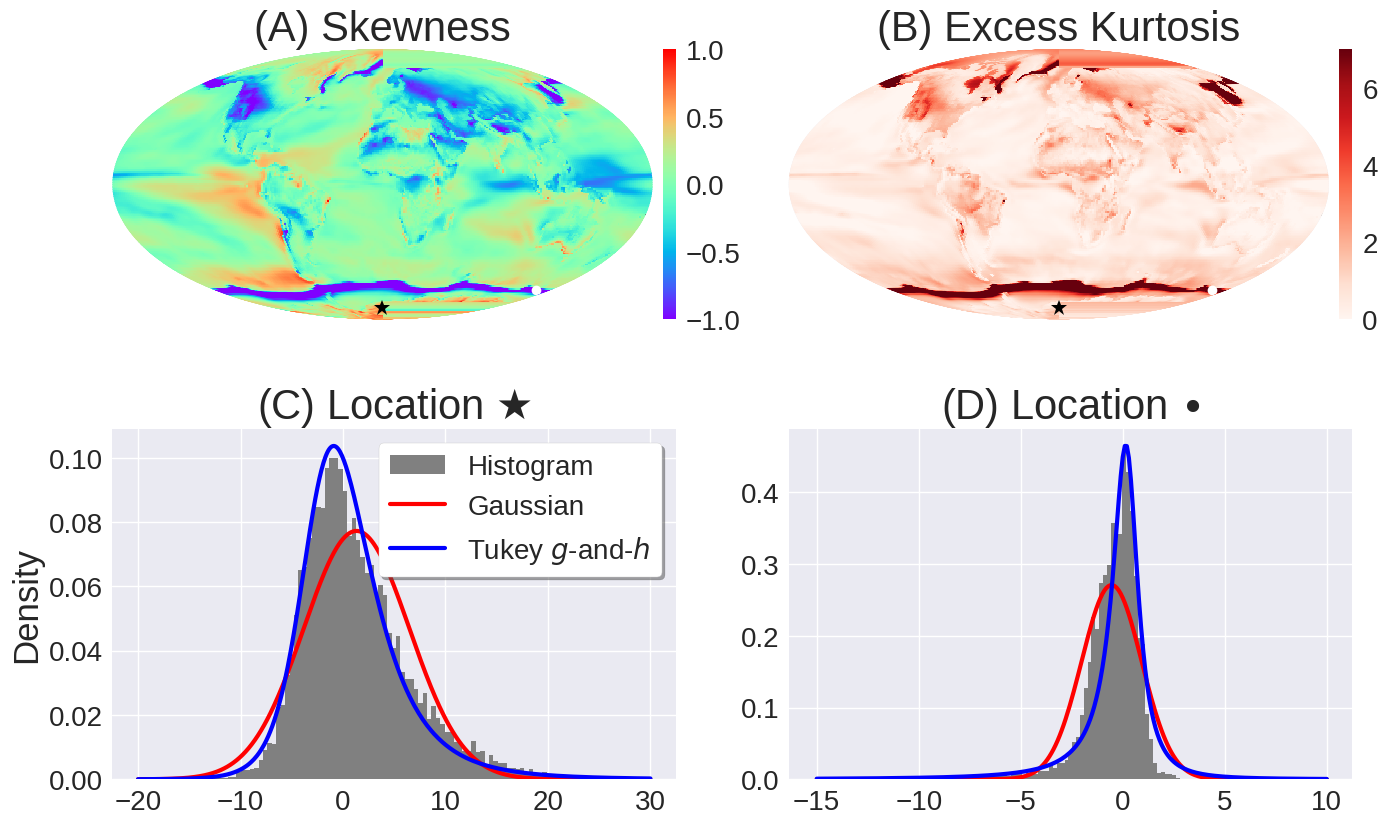

In [7]:
import matplotlib
matplotlib.style.use('seaborn')

resolution = 1
cm = plt.cm.rainbow

fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(2,2,1, projection=mollweide)

ax.coastlines()
surface = ax.pcolormesh(lon[::resolution], lat[::resolution], skewMap[::resolution,::resolution], 
              transform=ccrs.PlateCarree(),cmap = cm, vmin = (-1,1))

plt.title('(A) Skewness', fontsize = 30)

divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size="2.5%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(cax)
cbar = fig.colorbar(surface, cax=cax)
cbar.ax.tick_params(labelsize=20)

ax.plot(lon1, lat1, 'k*', ms=12, transform=ccrs.PlateCarree())
ax.plot(lon2, lat2, 'wo', ms=7, transform=ccrs.PlateCarree())


ax = fig.add_subplot(2,2,2, projection=mollweide)

ax.coastlines()
surface = ax.pcolormesh(lon[::resolution], lat[::resolution], kurMap[::resolution,::resolution]-3, 
              transform=ccrs.PlateCarree(),cmap = plt.cm.Reds, vmin = (0,7))

plt.title('(B) Excess Kurtosis', fontsize = 30)

divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size="2.5%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(cax)
cbar = fig.colorbar(surface, cax=cax)
cbar.ax.tick_params(labelsize=20)

ax.plot(lon1, lat1, 'k*', ms=12, transform=ccrs.PlateCarree())
ax.plot(lon2, lat2, 'wo', ms=7, transform=ccrs.PlateCarree())


plt.subplot(223)
plt.title('(C) Location $\u2605$', fontsize = 30)
plt.hist(residual1, bins = 100, density = True, color='gray', label = 'Histogram');
plt.plot(xList1, gaussian1, label = 'Gaussian', color = 'red', linewidth = 3)
plt.plot(xList1, tghFit1, label = 'Tukey $g$-and-$h$', color = 'blue', linewidth = 3)
plt.legend(fontsize = 20, frameon = True, facecolor = 'white', 
                 shadow = True, fancybox = True)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Density', fontsize = 25)

plt.subplot(224)
plt.title('(D) Location ' + r'$\bullet$', fontsize = 30)
plt.hist(residual2, bins = 100, density = True, color='gray', label = 'Histogram');
plt.plot(xList2, gaussian2, label = 'Gaussian', color = 'red', linewidth = 3)
plt.plot(xList2, tghFit2, label = 'Tukey $g$-and-$h$', color = 'blue', linewidth = 3)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.savefig('F6-skew-kurto.png', dpi = 150, bbox_inches = 'tight')